# Imports

In [1]:
import numpy as np
import data_preprocessing as dp
import plotting as p
import modeling as m

# Constants

In [2]:
de_shape_path = "data/Germany/germany_rect.shx"

de_s2_rasters = ["data/Germany/S2_germany_T33UUU_20220312.tif", "data/Germany/S2_germany_T33UUV_20220312.tif", 
                         "data/Germany/S2_germany_T33UVU_20220314.tif", "data/Germany/S2_germany_T33UVV_20220314.tif"]
de_s2_merged_path = "data/Germany/S2_merged_20220312-14.tif"
de_s2_path = 'data/Germany/S2_merged_20220312-14_reproj.tif'

de_terrasar_no_process_path = "data/Germany/dims_op_oc_dfd2_695017442_1/TSX-1.SAR.L1B/TSX1_SAR__MGD_SE___SM_S_SRA_20220523T052620_20220523T052628/IMAGEDATA/IMAGE_HH_SRA_strip_011.tif"
de_terrasar_path = "data/Germany/TerraSAR_20220523_reproj.tif"

de_iceye_no_process_path = "data/Germany/ICEYE_X11_GRD_SC_2631255_20230902T005432.tif_Cal_Spk_TC.tif"
de_iceye_path = 'data/Germany/ICEYE_X11_GRD_SC_20230902_reproj.tif'

DE_FIRST_LOCATION_RUN = False

EXPERIMENT_RUN = 'all'  # 'optical', 'iceye', 'all', 'terra'
NUM_SIMULATIONS = 8

PATCH_SIZE = 200           # patch size
OVERLAP = 0                # overlap between patches
TRAIN_RATIO = 0.8
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-3

# Data preprocessing

#### Set up

In [3]:
de_aoi = dp.get_aoi_geometry(de_shape_path, False)
de_aoi = de_aoi.set_crs("EPSG:4326", allow_override=True)

if DE_FIRST_LOCATION_RUN:
    dp.get_sentinel2(de_aoi, de_s2_path, de_s2_merged_path, ((0, 0), (0, 1), (0, 0)),
                      temp_file=de_s2_merged_path, list_files=de_s2_rasters
                      )
    dp.get_terrasar(de_aoi, de_terrasar_no_process_path, ((0, 0), (0, 1), (0, 1)), 
                        de_terrasar_path
                    )
    dp.get_iceye(de_aoi, de_iceye_path, ((0, 0), (0, 1)), de_iceye_no_process_path)
    dp.get_ref_data(de_aoi, 'data/Germany/ref_data_abg_woody.tif', ((1, 0), (0, 0)),
                     'data/Germany/60N_010E.tif'
                    )

#### Optical - Sentinel 2

In [4]:
de_s2_data,_ = dp.get_sentinel2(aoi=de_aoi, file_path=de_s2_path, 
                                             padding=((0, 0), (2, 2), (2, 1)), plot=False
                                             )

#### SAR - TerraSAR

In [5]:
de_terrasar_data,_ = dp.get_terrasar(aoi=de_aoi, 
                                                        file_path=de_terrasar_path, 
                                                        padding=((2, 2), (2, 1)), plot=False
                                                        )

#### SAR - Iceye

In [6]:
de_iceye_data,_ = dp.get_iceye(aoi=de_aoi, file_path=de_iceye_path, 
                                               padding=((2, 2), (2, 2)), plot=False
                                               )

#### Stacking

In [7]:
if EXPERIMENT_RUN == 'optical':
    de_combined = de_s2_data
elif EXPERIMENT_RUN == 'terra':
    de_combined = de_terrasar_data
elif EXPERIMENT_RUN == 'iceye':
    de_combined = de_iceye_data
elif EXPERIMENT_RUN == 'all':
    de_combined = np.concatenate((de_s2_data, de_terrasar_data, de_iceye_data), axis=0)

#### Reference data

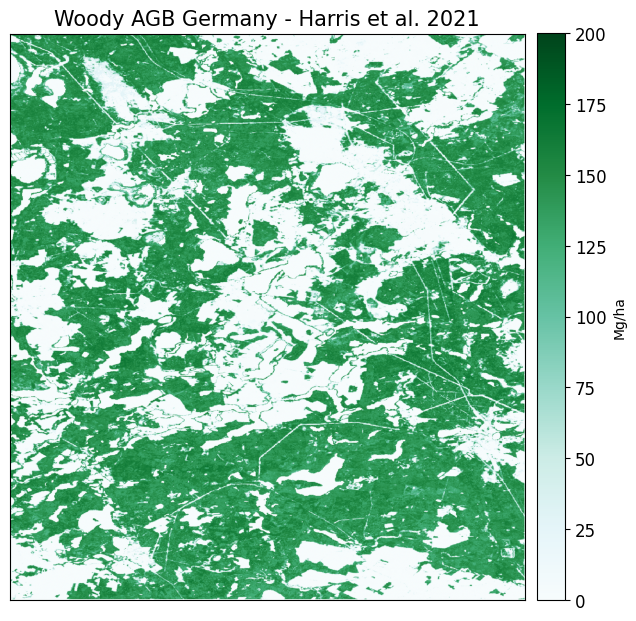

In [ ]:
de_ref_data,_ = dp.get_ref_data(de_aoi,'data/Germany/ref_data_abg_woody.tif', ((2, 2), (2, 1)), plot=False)


In [9]:
del de_s2_data, de_terrasar_data, de_iceye_data, de_shape_path, de_s2_rasters, \
    de_s2_merged_path, de_s2_path, de_terrasar_no_process_path, de_terrasar_path, \
    de_iceye_no_process_path, de_iceye_path

#### Formatting for models

In [10]:
de_n_bands, de_height, de_width = de_combined.shape
n_pixels = de_height * de_width

de_X_train, de_X_test, de_y_train, de_y_test, de_X_2d = dp.get_test_train_data(de_combined, n_pixels, de_n_bands, de_ref_data)

de_cnn_X_train, de_cnn_X_test, de_cnn_y_train, de_cnn_y_test, all_target_patches = dp.get_test_train_data(de_combined,
                                                                                                           n_pixels, 
                                                                                                           de_n_bands, 
                                                                                                           de_ref_data, 
                                                                                                           cnn=True,
                                                                                                           patch_size=PATCH_SIZE,
                                                                                                           overlap=OVERLAP)

In [11]:
del de_n_bands, n_pixels, de_combined, de_ref_data,

# Experiments

### MLR

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self

Training Time: 0.77 seconds
RMSE: 54.22875269136701 Mg/ha
R² Score: 0.37002623977822213


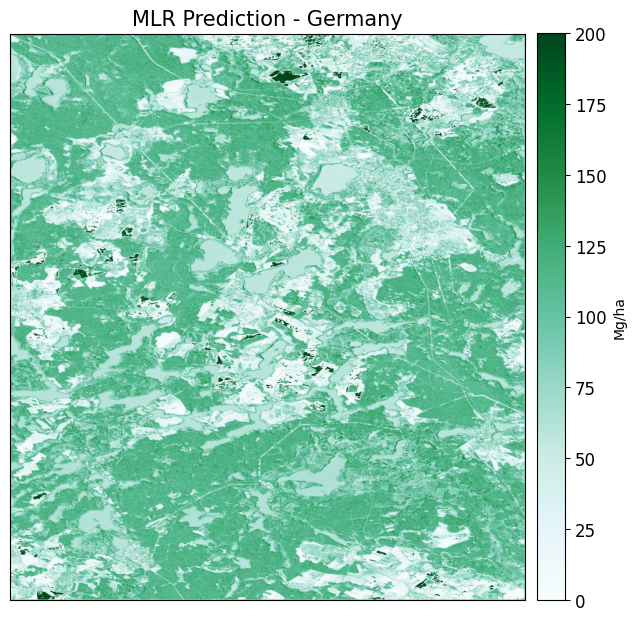

In [ ]:
# No need t run experiments in this bc mathematically deterministic
_, mlr_runtime, mlr_rmse, mlr_r2 = m.mlr(de_X_train, de_y_train, de_X_test, de_y_test, de_X_2d, de_height, de_width, output=False)

if DE_FIRST_LOCATION_RUN:
    with open('data/output/de.txt', 'a') as file:
        file.write('MLR control (%s):\n'%EXPERIMENT_RUN)
        file.write(str({'mlr': [mlr_runtime, mlr_rmse, mlr_r2]}))
        file.write('\n\n')

### RF

##### Parameter experiments

In [14]:
n_estimators = [50, 125, 200]
max_tree_depths = [10, 15, 30]

if EXPERIMENT_RUN == 'all':
    rf_output = m.parameter_experiments(n_estimators, max_tree_depths, NUM_SIMULATIONS, 'rf', de_X_train, de_y_train, de_X_test, 
                                de_y_test, de_X_2d, de_height, de_width)

    with open('data/output/de.txt', 'a') as file:
        file.write('RF Parameter Experiments Output:\n')
        file.write(str(rf_output))
        file.write('\n\n')
    
    del rf_output

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   14

##### Input data experiments

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   49.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    4.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


Training Time: 54.06 seconds
RMSE: 28.820173750770508 Mg/ha
R² Score: 0.8220670335571222


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.7s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   11.4s finished


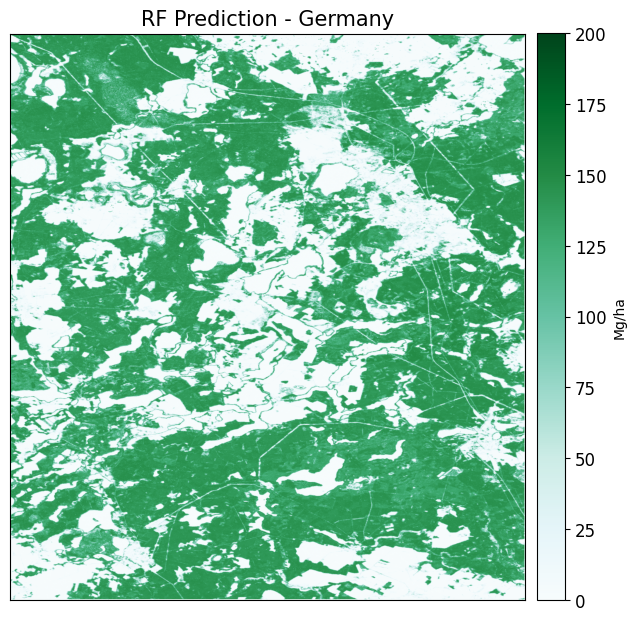

(array([ 97.09909091, 137.65471145, 144.84707347, ..., 121.82758591,
         18.8       , 144.54035599]),
 54.05913519859314,
 28.820173750770508,
 0.8220670335571222)

In [ ]:
if EXPERIMENT_RUN != 'all':
    input_experiment_output_rf = m.parameter_experiments([50], [30], NUM_SIMULATIONS, 'rf', de_X_train, de_y_train, de_X_test, 
                                de_y_test, de_X_2d, de_height, de_width)
    
    with open('data/output/de.txt', 'a') as file:
        file.write('RF Input Data Experiments Output (%s):\n' % EXPERIMENT_RUN)
        file.write(str(input_experiment_output_rf))
        file.write('\n\n')
    
    del input_experiment_output_rf

# m.rf(de_X_train, de_y_train, de_X_test, de_y_test, de_X_2d, de_height, de_width, output=True, num_trees=50, max_tree_depth=30)

### GBT

##### Parameter experiments

Training Time: 336.70 seconds
RMSE: 27.000747680664062 Mg/ha
R² Score: 0.8438237905502319


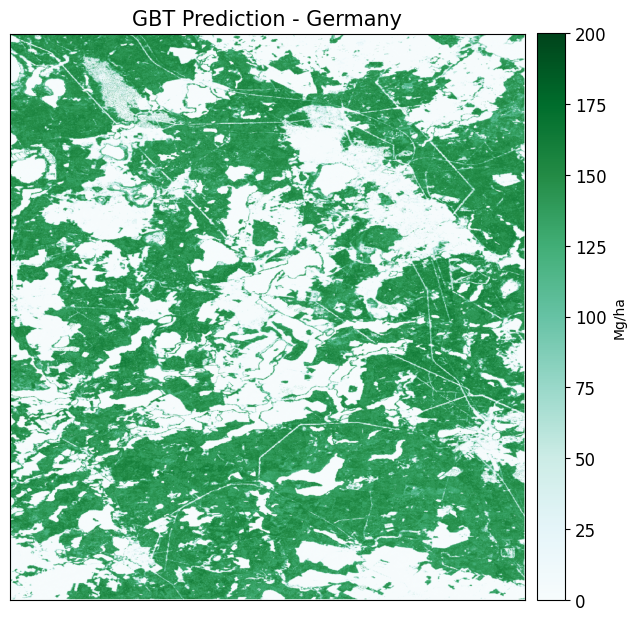

(array([ 98.16474   , 144.46793   , 149.55186   , ..., 118.85257   ,
          0.94199926, 145.27748   ], dtype=float32),
 336.7018229961395,
 27.000747680664062,
 0.8438237905502319)

In [ ]:
n_estimators = [50, 125, 200]
max_tree_depths = [10, 15, 30]

if EXPERIMENT_RUN == 'all':
    gbt_output = m.parameter_experiments(n_estimators, max_tree_depths, NUM_SIMULATIONS, 'gbt', de_X_train, de_y_train, de_X_test, 
                                de_y_test, de_X_2d, de_height, de_width)

    with open('data/output/de.txt', 'a') as file:
        file.write('GBT Parameter Experiments Output:\n')
        file.write(str(gbt_output))
        file.write('\n\n')
    
    del gbt_output

# m.gbt(de_X_train, de_y_train, de_X_test, de_y_test, de_X_2d, de_height, de_width, output=True, num_trees=50, max_tree_depth=30)

### CNNs

add vis and shit to help cnns

In [11]:
from sklearn.metrics import r2_score, root_mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPool2D, Conv2D, Conv2DTranspose, \
      Concatenate, Dropout, Dense, Activation, MaxPooling2D, \
      UpSampling2D, Flatten, BatchNormalization, Add, Resizing, concatenate
from tensorflow.keras.optimizers import Adam
import time

In [12]:
def cnn(X_train, y_train, X_test, y_test, original_shape=(0,0,0), output=False, patch_size=200, 
        architecture='simple'):
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    inputs = tf.keras.Input(shape=input_shape)

    if architecture=='simple':
        x = Conv2D(16, kernel_size=3, padding='same', activation='relu')(inputs)
        x = MaxPooling2D(2)(x)

        # Residual blocks
        for i in range(1):
            x = Conv2D(2**(i+3), kernel_size=3, padding='same', activation='relu')(x)

        x = UpSampling2D(2)(x)

        # Optional post-processing
        x = Conv2D(1, 3, padding='same', activation='linear')(x)

        # x = UpSampling2D()

        model = Model(inputs, x)
        model.summary()

    elif architecture=='resnet':
        # Initial conv
        x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(inputs)
        x = BatchNormalization()(x)

        # Residual blocks
        for i in range(5):
            x = m.residual_block(x, 64)

        # Optional post-processing
        x = Conv2D(16, kernel_size=3, padding='same', activation='relu')(x)
        x = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')(x)

        model = Model(inputs, x)


    elif 'unet':
        # Contracting Path (Encoder)
        c1 = m.unet_encoder_block(inputs, 64)
        c2 = m.unet_encoder_block(c1, 128)
        c3 = m.unet_encoder_block(c2, 256)
        c4 = m.unet_encoder_block(c3, 512)

        # Bottleneck
        b1 = m.unet_encoder_block(c4, 1024, bottleneck=True)

        # Expanding Path (Decoder)
        c5 = m.unet_decoder_block(b1, c4, 512) 
        c6 = m.unet_decoder_block(c5, c3, 256) 
        c7 = m.unet_decoder_block(c6, c2, 128) 
        c8 = m.unet_decoder_block(c7, c1, 64) 

        # Output layer
        c8 = Resizing(X_train.shape[1], X_train.shape[2])(c8)
        outputs = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(c8)

        # Define the model
        model = Model(inputs, outputs, name='U-Net')
        
    elif 'googlenet': # too complicated
        model = Model()

    elif 'alexanet':
            # Conv Layer 1
        x = Conv2D(96, (11, 11), strides=(4, 4), activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

        # Conv Layer 2
        x = Conv2D(256, (5, 5), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

        # Conv Layer 3
        x = Conv2D(384, (3, 3), padding='same', activation='relu')(x)

        # Conv Layer 4
        x = Conv2D(384, (3, 3), padding='same', activation='relu')(x)

        # Conv Layer 5
        x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
        x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

        # Fully Connected Layers
        x = Flatten()(x)
        x = Dense(4096, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(4096, activation='relu')(x)
        x = Dropout(0.5)(x)

        # Output Layer for Regression (No activation)
        output_layer = Dense(1, activation=None)(x)

        model = Model(inputs=inputs, outputs=output_layer)

    if output:
        model.summary()

    model.compile(
        optimizer = Adam(learning_rate=0.01), # increasing learning rate helps a lot!!!! stops from getting stuck in holes
        loss='mse',
        metrics=['root_mean_squared_error', m.cnn_r2_score]
    )

    # 6. Train using NumPy arrays
    model.fit(
        x=X_train,
        y=y_train,
        batch_size=16,
        # validation_data=(X_test, y_test),
        epochs=10
    )

    return model

In [13]:
_, cnn_runtime, cnn_rmse, cnn_r2 = cnn(de_cnn_X_train, de_cnn_y_train, de_cnn_X_test, de_cnn_y_test, 
                                         output=True, patch_size=200, original_shape=all_target_patches.shape[-1],
                                         architecture='reuse')

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 14)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 200, 200,  │      8,128 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 200, 200,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 200, 200,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 200, 200,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 100, 100,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 100,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 100, 100,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 100, 100,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 100, 100,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 50, 50,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 50, 50,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 50, 50,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 50, 50,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 50, 50,    │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 25, 25,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 25, 25,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,038,081 (118.40 MB)

 Trainable params: 31,038,081 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - cnn_r2_score: 0.0323 - loss: 11328.4766 - root_mean_squared_error: 106.4310
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step - cnn_r2_score: 0.0000e+00 - loss: 11528.4473 - root_mean_squared_error: 107.3690
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step - cnn_r2_score: 0.0000e+00 - loss: 11436.4922 - root_mean_squared_error: 106.9374
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step - cnn_r2_score: 0.0000e+00 - loss: 11415.6689 - root_mean_squared_error: 106.8426
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step - cnn_r2_score: 0.0000e+00 - loss: 11378.5020 - root_mean_squared_error: 106.6689
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step - cnn_r2_score: 0.0000e+00 - loss: 11552.8086 - root_mean_squared_error: 107.4740
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step - cnn_r2_score: 0.0000e+00 - loss: 11447.9707 - root_mean_squared_error: 106.9946
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step - cnn_r2_score: 0.0000e+00 - loss: 11465.0215 

TypeError: cannot unpack non-iterable Functional object

In [ ]:
de_combined = np.nan_to_num(np.expand_dims(np.transpose(de_combined, (1, 2, 0)),axis=0), nan=0.0, posinf=0.0, neginf=0.0)
de_ref_data = np.nan_to_num(np.expand_dims(np.transpose(de_ref_data, (1, 2, 0)),axis=0), nan=0.0, posinf=0.0, neginf=0.0)

In [ ]:
model = cnn(de_combined, de_ref_data, de_cnn_X_test, de_cnn_y_test, 
            output=False, patch_size=200, original_shape=all_target_patches.shape[-1],
            architecture='unet')

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 373s 373s/step - cnn_r2_score: 0.1289 - loss: 11880.7402 - root_mean_squared_error: 108.9988
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - cnn_r2_score: 0.0000e+00 - loss: 11796.1172 - root_mean_squared_error: 108.6099
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 211s 211s/step - cnn_r2_score: 0.0000e+00 - loss: 11796.1172 - root_mean_squared_error: 108.6099
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 206s 206s/step - cnn_r2_score: 0.0000e+00 - loss: 11796.1172 - root_mean_squared_error: 108.6099
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 206s 206s/step - cnn_r2_score: 0.0000e+00 - loss: 11796.1172 - root_mean_squared_error: 108.6099
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 209s 209s/step - cnn_r2_score: 0.0000e+00 - loss: 11796.1172 - root_mean_squared_error: 108.6099
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 205s 205s/step - cnn_r2_score: 0.0000e+00 - loss: 11796.1172 - root_mean_squared_error: 108.6099
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 214s 214s/step - cnn_r2_score: 0.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


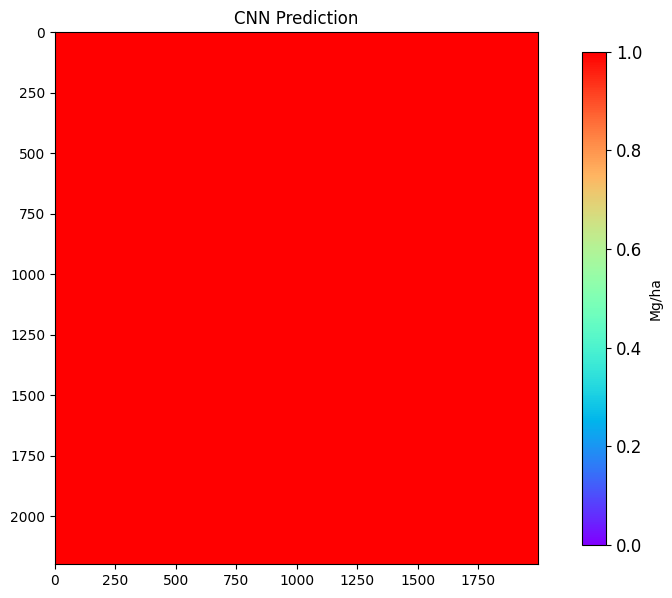

In [ ]:
import plotting as p

predicted_output = model.predict(de_combined)

p.plot_raster(predicted_output[0], 'CNN Prediction', 'rainbow', normalized=True, cbar_label='Mg/ha')